# Building Recommendation System

## Import the Packages

In [15]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
from collections import defaultdict
import csv
from numpy import genfromtxt
import pickle
import tabulate
pd.set_option("display.precision", 1)

## Get the dataset

In [16]:
data = pd.read_csv('Data/user_reviews.csv')
data

,productname,rating,user_id,category
0,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,Pestisida & Obat Pertanian
1,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dimas,Pestisida & Obat Pertanian
2,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,Pestisida & Obat Pertanian
3,"herbisida obat pembasmi rumput liar, gulma, al...",5,Rezky,Pestisida & Obat Pertanian
4,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dendy,Pestisida & Obat Pertanian
...,...,...,...,...
174891,"herbisida obat pembasmi rumput liar, gulma, al...",2,4qv00hrohw,Pestisida & Obat Pertanian
174892,INFARM - Pupuk Organik Cair Tanaman Buah / Bun...,2,4qv00hrohw,Pupuk dan Nutrisi Tanaman
174893,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3,4qv00hrohw,Pupuk dan Nutrisi Tanaman
174894,Mangga Harum Manis (1kg) Sayurbox,2,4qv00hrohw,Produk Pertanian Segar


In [17]:
from sklearn.preprocessing import OneHotEncoder
# one hot encode the category data
Ohe = OneHotEncoder()
category = Ohe.fit_transform(data[['category']])
category = category.toarray()
category = pd.DataFrame(category, columns = Ohe.get_feature_names_out(['category']))
data = pd.concat([data, category], axis=1)
data = data.drop('category', axis=1)
data

,productname,rating,user_id,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dimas,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,"herbisida obat pembasmi rumput liar, gulma, al...",5,Bambang,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,"herbisida obat pembasmi rumput liar, gulma, al...",5,Rezky,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,"herbisida obat pembasmi rumput liar, gulma, al...",5,Dendy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174891,"herbisida obat pembasmi rumput liar, gulma, al...",2,4qv00hrohw,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
174892,INFARM - Pupuk Organik Cair Tanaman Buah / Bun...,2,4qv00hrohw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
174893,Pupuk Cair Daun Super Spray Siap Pakai by BLOO...,3,4qv00hrohw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
174894,Mangga Harum Manis (1kg) Sayurbox,2,4qv00hrohw,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
# get unique users_id
users_id = data.user_id.unique()

# # get data where user_id = 1
# user1 = data[data.user_id == 1]

# # multiply rating to each category
# category = user1.iloc[:, 3:].multiply(user1['rating'], axis=0)

# # sum each category
# category_sum = category.sum(axis=0)

# # count value that is not zero
# category_not_zero = category[category != 0]

# # calculate average rating
# category_avg = category_sum / category_not_zero.count()

# # transform it to dataframe
# category_avg = category_avg.to_frame().T

# # count rating
# rating_count = user1.shape[0]

# # make a new dataframe
# user1_new = pd.DataFrame({'user_id': [1], 'rating_count': [rating_count]})

# # merge the data
# user1_new = pd.concat([user1_new, category_avg], axis=1)
# user1_new.fillna(0, inplace=True)
# user1_new
# Repeat the process for each user_id
user_profiles = []

for user in users_id:
    user_data = data[data.user_id == user]
    category = user_data.iloc[:, 3:].multiply(user_data['rating'], axis=0)
    category_sum = category.sum(axis=0)
    category_not_zero = category[category != 0]
    category_avg = category_sum / category_not_zero.count()
    category_avg = category_avg.to_frame().T
    rating_count = user_data.shape[0]
    user_new = pd.DataFrame({'user_id': [user], 'rating_count': [rating_count]})
    user_new = pd.concat([user_new, category_avg], axis=1)
    user_new.fillna(0, inplace=True)
    user_profiles.append(user_new)

# Concatenate all user profiles into a single DataFrame
user_profiles_df = pd.concat(user_profiles, ignore_index=True)
user_profiles_df

,user_id,rating_count,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,Bambang,169,3.4,3.8,3.8,3.7,4.2,3.4,3.3,3.3,3.8,3.8
1,Dimas,65,3.6,3.8,4.0,3.7,4.1,3.0,3.2,3.8,3.3,3.4
2,Rezky,16,3.0,3.5,3.5,3.0,4.5,0.0,2.5,5.0,2.3,0.0
3,Dendy,28,3.0,3.5,4.0,3.4,4.5,4.0,2.5,4.0,2.6,2.0
4,Victor,45,4.0,4.0,3.7,3.2,3.8,3.0,3.6,5.0,3.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19150,hJJJJJ1,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19151,hfffff1,1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19152,hFFFFF1,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
19153,hnnnnn1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
user_data = data[["user_id"]]
user_data = user_data.merge(user_profiles_df, on="user_id", how="left")


In [25]:
# label encode the user_id
user_data["user_id"] = user_data["user_id"].astype('category')
user_data["user_id"] = user_data["user_id"].cat.codes

In [22]:
# Transform product into label encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
product_data = label_encoder.fit_transform(data['productname'])
product_data = pd.DataFrame(product_data, columns=['product_id'])
product_data = product_data.merge(data, left_index=True, right_index=True)
product_data.drop(["user_id", "productname"], axis=1, inplace=True)
product_data

,product_id,rating,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,189,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,189,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,189,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,189,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,189,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
174891,189,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
174892,62,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
174893,121,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
174894,98,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
# scale training data
item_train_unscaled = product_data.drop('rating', axis=1).values
user_train_unscaled = user_data
y_train_unscaled    = product_data['rating'].values

scalerItem = StandardScaler()
scalerItem.fit(product_data.drop('rating', axis=1))
item_train = scalerItem.transform(product_data.drop('rating', axis=1))

scalerUser = StandardScaler()
scalerUser.fit(user_data)
user_train = scalerUser.transform(user_data)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(product_data['rating'].values.reshape(-1, 1))
y_train = scalerTarget.transform(y_train_unscaled.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


In [88]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"product/item training data shape: {item_train.shape}")
print(f"product/item test data shape: {item_test.shape}")

product/item training data shape: (111932, 11)
product/item test data shape: (27984, 11)


In [89]:
# make the dataset to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({"user": user_train, "item": item_train}, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(({"user": user_test, "item": item_test}, y_test))

# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
test_dataset = test_dataset.batch(64)

# prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [99]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_user_features = user_train.shape[1]
num_item_features = item_train.shape[1]

# Example item metadata features (e.g., genres, keywords, etc.)
num_outputs = 24
user_NN = tf.keras.Sequential()
item_NN = tf.keras.Sequential()
# Define a function to create a residual block
def residual_block(x, units):
    shortcut = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, shortcut])
    return x

# User network with residual connections
user_input = tf.keras.layers.Input(shape=(num_user_features,))
x = tf.keras.layers.Dense(1024, activation='relu')(user_input)
x = residual_block(x, 1024)
x = residual_block(x, 512)
x = residual_block(x, 256)
x = residual_block(x, 128)
x = residual_block(x, 64)
user_NN = tf.keras.Model(user_input, x)

# Item network with residual connections
item_input = tf.keras.layers.Input(shape=(num_item_features,))
x = tf.keras.layers.Dense(1024, activation='relu')(item_input)
x = residual_block(x, 1024)
x = residual_block(x, 512)
x = residual_block(x, 256)
x = residual_block(x, 128)
x = residual_block(x, 64)
item_NN = tf.keras.Model(item_input, x)

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 11)]         0           []                               
                                                                                                  
 model_17 (Functional)          (None, 64)           4913728     ['input_36[0][0]']               
                                                                                                  
 model_18 (Functional)          (None, 64)           4912704     ['input_37[0][0]']               
                                                                                           

In [100]:
# Example training process
cost_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss=cost_fn)

# Train the model
history = model.fit([user_train, item_train], y_train, epochs=100, validation_data=([user_test, item_test], y_test))

Epoch 1/100
3498/3498 [==============================] - 47s 13ms/step - loss: 0.2415 - val_loss: 0.2106
Epoch 2/100
3498/3498 [==============================] - 43s 12ms/step - loss: 0.2082 - val_loss: 0.2000
Epoch 3/100
3498/3498 [==============================] - 41s 12ms/step - loss: 0.1988 - val_loss: 0.1950
Epoch 4/100
3498/3498 [==============================] - 41s 12ms/step - loss: 0.1929 - val_loss: 0.1895
Epoch 5/100
3498/3498 [==============================] - 42s 12ms/step - loss: 0.1885 - val_loss: 0.1872
Epoch 6/100
3498/3498 [==============================] - 42s 12ms/step - loss: 0.1848 - val_loss: 0.1863
Epoch 7/100
3498/3498 [==============================] - 43s 12ms/step - loss: 0.1820 - val_loss: 0.1844
Epoch 8/100
3498/3498 [==============================] - 41s 12ms/step - loss: 0.1800 - val_loss: 0.1817
Epoch 9/100
3498/3498 [==============================] - 42s 12ms/step - loss: 0.1780 - val_loss: 0.1820
Epoch 10/100
3498/3498 [==============================]

In [101]:
model.save('Model/recsysNN_model.h5')

In [37]:
model.evaluate([user_test, item_test], y_test)

1094/1094 [==============================] - 4s 3ms/step - loss: 0.2036


0.20362991094589233

dict_keys(['loss', 'val_loss'])


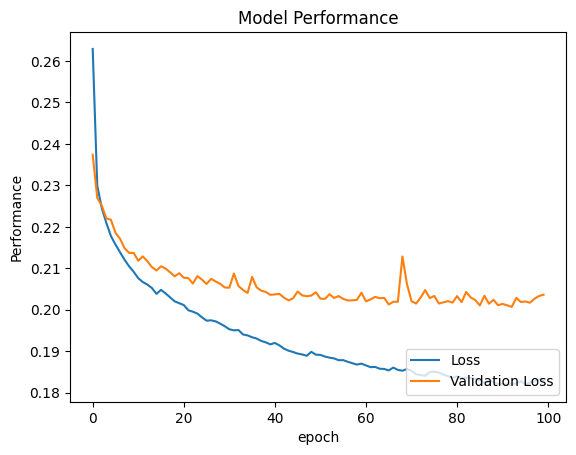

In [38]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [81]:
# create a new dataframe for the user
user_new = pd.DataFrame({'user_id': [19155],
                         'rating_count': [10],
                         'category_Alat dan Mesin Pertanian': [4.8],
                         'category_Bahan Pengemasan dan Logistik': [0.0],
                         'category_Bibit dan Benih Tanaman': [3.0],
                         'category_Perlengkapan Rumah Kaca dan Pembibitan': [0.0],
                         'category_Pestisida & Obat Pertanian': [5.0],
                         'category_Produk Olahan Pertanian': [5.0],
                         'category_Produk Pertanian Segar': [2.0],
                         'category_Pupuk dan Nutrisi Tanaman': [5.0],
                         'category_Sarana dan Peralatan Irigasi': [4.0],
                         'category_Teknologi Pertanian': [3.8],
                         })

user_new

,user_id,rating_count,category_Alat dan Mesin Pertanian,category_Bahan Pengemasan dan Logistik,category_Bibit dan Benih Tanaman,category_Perlengkapan Rumah Kaca dan Pembibitan,category_Pestisida & Obat Pertanian,category_Produk Olahan Pertanian,category_Produk Pertanian Segar,category_Pupuk dan Nutrisi Tanaman,category_Sarana dan Peralatan Irigasi,category_Teknologi Pertanian
0,19155,10,4.8,0.0,3.0,0.0,5.0,5.0,2.0,5.0,4.0,3.8


In [82]:
# try to predict recommendation for user 19155
user_new["user_id"] = user_new["user_id"].astype('category')
user_new["user_id"] = user_new["user_id"].cat.codes
user_new = scalerUser.transform(user_new)
user_new

array([[-1.20157877, -0.48500979,  1.26668964, -1.47330559,  0.07329747,
        -2.0950376 ,  1.35188697,  1.3571154 , -0.38643884,  1.38554403,
         0.67511435,  0.66059916]])

In [83]:
# predict the recommendation
user_new_repeated = np.repeat(user_new, item_train.shape[0], axis=0)
prediction = model.predict([user_new_repeated, item_train])
prediction = scalerTarget.inverse_transform(prediction)
prediction = prediction.reshape(-1)
prediction

4373/4373 [==============================] - 8s 2ms/step


array([3.3319523, 3.2511775, 3.5970962, ..., 4.2234535, 3.2513626,
       3.331745 ], dtype=float32)

In [84]:
# get the top 10 recommendation
top_10_idx = np.argsort(prediction)[-10:][::-1]

# get the product name
product_names = data['productname']

# filter top_10_idx to ensure it is within bounds
top_10_idx = [idx for idx in top_10_idx if idx < len(product_names)]

# get the product names for the top 10 recommendations
top_10_products = product_names.iloc[top_10_idx]
top_10_products

88012     Pupuk organik/vitamin/nutrisi tanaman VIT-O 1 ...
122010    Plastik Wrapping / Stretch Film Hitam 15 cm / ...
26550     Keripik Apel standart 100 gram kripik buah Malang
71421     INFARM - Pupuk Organik Cair Tanaman Cabai 100 ...
71344     SELANG AIR PERMETER / SELANG ANTI LUMUT 1/2 5/...
26720            Pisang (Banana) Cavendish (500gr) Sayurbox
6869      Minyak Kelapa Ikan Dorang Spesial 4 pcs x 450m...
138288    Jaring atap/teduh Paranet shade net 75% list t...
70984     herbisida obat pembasmi rumput liar, gulma, al...
70712     BUBBLE WRAP ROLL 30CM X 50 METER BUBLE WRAP - ...
Name: productname, dtype: object

In [85]:
# get product dataset
product_dataset = pd.read_csv('Data/product.csv')
product_dataset

,productname,productdescription,rating,sellerid,price,stock,image,category
0,"obat pembasmi pohon dan akar, racun pohon, sta...",Nufarm Starlon Herbisida Sistemik\n\nIsi : 100...,4.9,she-basmi,Rp38.000,96653,9a6345e2-6ae6-4a44-b7cd-042a0a0e6f8b,Pestisida dan Obat tanaman
1,100ml Pestisida Organik Neem Oil /Minyak Mimba...,Takaran 1 sendok utk 1 liter larutan siap paka...,4.9,Panda Farm,Rp25.500,91,58835cb1-a00a-437b-9132-35f538e6bae1,Pestisida dan Obat tanaman
2,Antracol Fungisida-Obat Jamur Tanaman 70WP-250gr,Isi : 250gr\nExp : 01/25\n\nAntracol adalah fu...,4.9,benihkita,Rp49.550,33,3603111_2f32cce9-11e1-4106-8c35-ce50f50f69f3_7...,Pestisida dan Obat tanaman
3,"DESTHIN obat hama tanaman, ulat, kutu putih, h...","kemasan 500ml\n\nsudah menggunakan spray baru,...",4.9,she-basmi,Rp35.000,95969,e6dc4ec2-d4be-4565-b2db-8e51b1624dc2,Pestisida dan Obat tanaman
4,"herbisida obat pembasmi rumput liar, gulma, al...","Kemasan botol 500ml\n\nbotol rusak, bocor, spr...",4.9,she-basmi,Rp35.000,95886,618a27c5-a666-4d96-91b0-29f7d74fcc11,Pestisida dan Obat tanaman
...,...,...,...,...,...,...,...,...
144,ISKU Pressure Sprayer 1L/2L Botol Semprotan Ta...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,3989000000,4250,id-11134207-7r98q-lvd27q0a7htx37,Alat dan Mesin Pertanian
145,ISKU Semprotan Rumput Sprayer 5L Dan Botol Sem...,ãTerima kasih atas kepercayaan dan dukungan ...,5.0,Isku Official Shop,12499000000,2439,id-11134207-7r98s-lwffeqkx4o3hb9,Alat dan Mesin Pertanian
146,[2PCS] ISKU Alat Semprot Tanaman 5L Dan Botol ...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,15899000000,2284,id-11134207-7r98y-lwffeqkwdyqy6b,Alat dan Mesin Pertanian
147,ISKU Gunting Rumput Taman Gunting tanaman gunt...,ãTerima kasih atas kepercayaan dan dukungan ...,4.9,Isku Official Shop,9989000000,7909,sg-11134201-23010-4w2r3464n4lv74,Alat dan Mesin Pertanian


In [86]:
# get the product details for the top 10 recommendations
top_10_products_details = product_dataset[product_dataset['productname'].isin(top_10_products)]
top_10_products_details

,productname,productdescription,rating,sellerid,price,stock,image,category
4,"herbisida obat pembasmi rumput liar, gulma, al...","Kemasan botol 500ml\n\nbotol rusak, bocor, spr...",4.9,she-basmi,Rp35.000,95886,618a27c5-a666-4d96-91b0-29f7d74fcc11,Pestisida dan Obat tanaman
7,Pisang (Banana) Cavendish (500gr) Sayurbox,Pisang cavendish adalah pisang unggul dengan w...,4.9,Sayurbox,Rp13.100,91,14d831e2-3fc1-4515-9065-e1f3b7c70770.png,Produk Pertanian Segar
16,SELANG AIR PERMETER / SELANG ANTI LUMUT 1/2 5/...,? Produk High quality\n? Sedia COD !\n? Resell...,4.9,Amini-toko,Rp3.600,335,af37e32d-0b1e-4050-ad98-8bf111af1ced,Sarana dan PeralatanIrigasi
33,Plastik Wrapping / Stretch Film Hitam 15 cm / ...,"Supplier Wrapping TERLENGKAP, TERMURAH & READY...",5.0,Mitra Packindo Machinery,"Rp16,000",562.0,VqbcmM/2024/9/25/cdcdcdc2-3482-4926-806b-6b33a...,Bahan Pengemasan dan Logistik
37,Keripik Apel standart 100 gram kripik buah Malang,Oleh oleh khas Malang Keripik buah Apel Kualit...,4.9,kripio,"Rp16,500",50.0,product-1/2020/8/11/869195694/869195694_c5d5a7...,Produk Olahan Pertanian
40,Jaring atap/teduh Paranet shade net 75% list t...,Fungsi paranet (Shading Net) 1. Roff Insulatio...,4.9,Muda Mendunia official store,"Rp14,000",97988.0,VqbcmM/2023/7/17/54afaca4-73b1-489c-8fd0-2b357...,Perlengkapan Rumah Kaca dan Pembibitan
55,BUBBLE WRAP ROLL 30CM X 50 METER BUBLE WRAP - ...,PREMIUM adalah bubble dengan ukuran sama tapi ...,5.0,MC Phone Surabaya,"Rp23,900",869.0,VqbcmM/2022/4/12/76a4ab7f-3606-4393-8142-43e17...,Bahan Pengemasan dan Logistik
56,Minyak Kelapa Ikan Dorang Spesial 4 pcs x 450m...,"BeliÂ 1Â Pack,Â DapatÂ 4Â pouchÂ @Â 450Â mlÂ M...",5.0,KaiMarket,"Rp62,900",21.0,VqbcmM/2021/5/20/cb5ef9eb-1ea9-47c1-9fc4-54ff7...,Produk Olahan Pertanian
92,INFARM - Pupuk Organik Cair Tanaman Cabai 100 ...,Selamat datang di ðð»ð³ð®ð¿ðº ð...,4.9,Infarm.id Official Shop,1995100000,999908,sg-11134201-7qvg9-leqvy80slmgrec,Pupuk dan Nutrisi Tanaman
103,INFARM - Pupuk Organik Cair Tanaman Cabai 100 ...,Selamat datang di ðð»ð³ð®ð¿ðº ð...,4.9,infarmjakarta,1995100000,4,sg-11134201-7qvg9-leqvy80slmgrec,Pupuk dan Nutrisi Tanaman


In [107]:
tf.keras.backend.clear_session()

In [110]:
# transform keras model into tfjs model
import tensorflowjs
import shutil
import os
import tensorflow as tf

# Reset the default graph to avoid AlreadyExistsError
tf.keras.backend.clear_session()

# Remove the existing directory if it exists
tfjs_model_dir = 'Model/recsysNN_model_tfjs'
if os.path.exists(tfjs_model_dir):
    shutil.rmtree(tfjs_model_dir)

tfjs.converters.save_keras_model(model, tfjs_model_dir)

# save the scaler
with open('Model/scalerItem.pkl', 'wb') as f:
    pickle.dump(scalerItem, f)

with open('Model/scalerUser.pkl', 'wb') as f:
    pickle.dump(scalerUser, f)

with open('Model/scalerTarget.pkl', 'wb') as f:
    pickle.dump(scalerTarget, f)

# save the label encoder
with open('Model/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# save the one hot encoder
with open('Model/one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(Ohe, f)


AlreadyExistsError: Another metric with the same name already exists.